Copyright 2019 Carsten Blank

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
import datetime
import pytz
%load_ext autoreload

In [2]:
%autoreload 2
%aimport lib_experimental_utils

In [3]:
# Uncomment if you have not set up the PYTHONPATH to point to the code!
# import os
# import sys
# sys.path.append("{}/../lib_paper".format(os.getcwd()))

In [4]:
from typing import Optional

import qiskit
from qiskit.providers.aer.noise.device import basic_device_noise_model
from qiskit.providers.models import BackendProperties
import lib_experimental_utils as lib
from lib_experimental_utils import FinishedExperiment, RunningExperiment, qasm_simulator, get_gate_times

## Interesting
Good results:
* 5c962f6581cbf700560b9504
* 5c9755f199c2c6005f6bc532

Withou any barriers (except measurement)
* 5c975badf4e1bf0057a03d2b
* 5c976069adfd43005f0fef6b (+ 0.2pi theta correction)

In [5]:
experiment = FinishedExperiment.from_data(job_id='5c975badf4e1bf0057a03d2b', backend='ibmqx4')

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[2];
u3(0.0,-pi/2,pi/2) q[3];
u3(1.57079632679490,-1.57079632679490,3.14159265358979) q[2];
u2(0,pi) q[1];
cx q[2],q[0];
cx q[1],q[0];
u2(0,pi) q[1];
u2(0,pi) q[0];
cx q[3],q[2];
u2(0,pi) q[2];
cx q[3],q[2];
u3(pi/4,pi/2,3*pi/2) q[3];
cx q[3],q[4];
u3(-pi/4,pi/2,3*pi/2) q[3];
cx q[3],q[2];
u3(pi/4,pi/2,3*pi/2) q[3];
cx q[3],q[4];
u3(-pi/4,pi/2,3*pi/2) q[3];
u2(0,pi) q[4];
u2(pi/4,pi) q[2];
cx q[4],q[2];
u1(pi/4) q[4];
u1(-pi/4) q[2];
cx q[4],q[2];
cx q[3],q[2];
u2(0,pi) q[4];
barrier q[0],q[1],q[2],q[3],q[4];
measure q[4] -> c[0];
measure q[1] -> c[1];



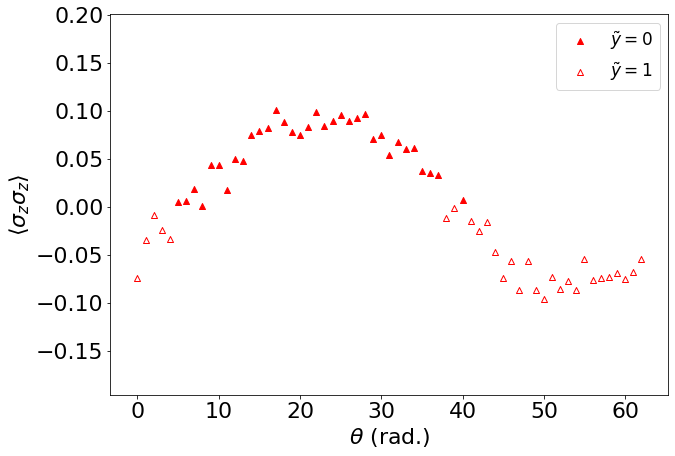

In [6]:
experiment.show_plot()
print(experiment.qobj.experiments[0].header.compiled_circuit_qasm)

In [7]:
backend = qiskit.IBMQ.get_backend(experiment.backend_name)
device_properties = backend.properties()  # type: Optional[BackendProperties]
gate_times = get_gate_times(backend)
noise_model = basic_device_noise_model(device_properties, gate_times=gate_times, temperature=0) 

In [8]:
simulation = RunningExperiment(date=datetime.datetime.now().astimezone(tz=pytz.UTC), 
                               qobj=experiment.qobj, 
                               job=qasm_simulator.run(qobj=experiment.qobj, noise_model=noise_model),
                               external_id='{}'.format(experiment.date),
                               noise_model=noise_model)
simulation = FinishedExperiment.from_running_experiment(simulation)
simulation.parameters['device_properties'] = device_properties.to_dict()
simulation.parameters['gate_times'] = gate_times

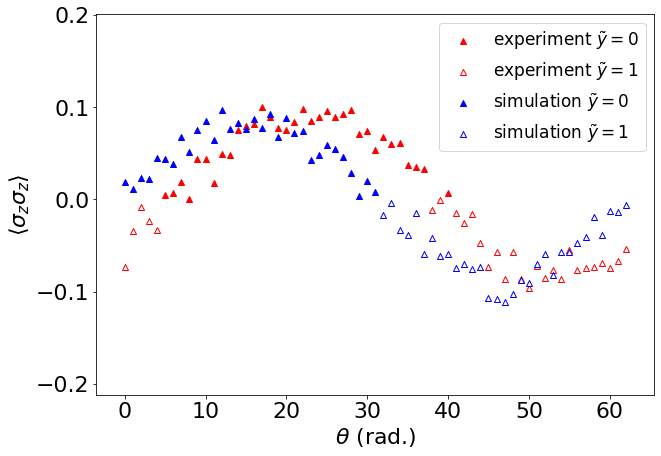

In [9]:
experiment.show_plot(classification_label='experiment', compare_classification=simulation.get_classification(), compare_classification_label='simulation')

In [10]:
lib.save(directory='../../experiment_results', experiment=experiment, simulation=simulation)
